\begin{center} 
Chun-Yuan (Scott) Chiu 
\end{center}

\begin{center} 
chunyuac@andrew.cmu.edu 
\end{center} 

# 1. {-}

## (a) {-}

In [4]:
# contents of problem1.py

import numpy as np

def get_data(n):
#     np.random.seed(0)               # fix seed
    x = np.random.uniform(size=n)
    y = x**2-x/2.0 + np.random.normal(size=n,scale=0.1)
    idx = np.argsort(x)
    return(x[idx].reshape((-1,1)),y[idx].reshape((-1,1)))

def true_mean(x):
    return(x**2-x/2.0)


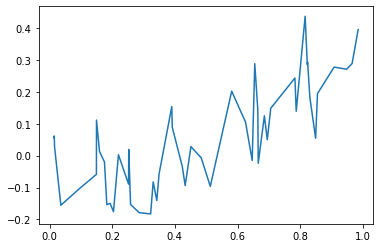

In [5]:
import matplotlib.pyplot as plt

X_train, y_train = get_data(50)
plt.plot(X_train, y_train)
plt.show()

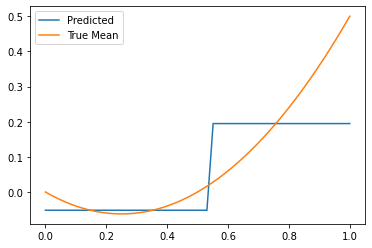

In [6]:
from sklearn.tree import DecisionTreeRegressor
from pandas import DataFrame

tree = DecisionTreeRegressor(max_depth=1).fit(X_train, y_train)
xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
df = DataFrame({'Predicted': tree.predict(xgrid), 'True Mean': true_mean(xgrid).flatten()}, index=xgrid.flatten())
df.plot()
plt.show()

## (b) {-}

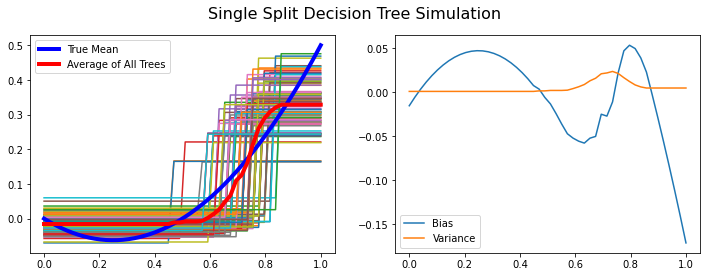

In [8]:
def tree1d(suptitle, n_sim=100, **DTkwarg):
    xgrid = np.array(np.linspace(0, 1, num=50)).reshape(50, 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle(suptitle, fontsize=16)
    
    pred = []
    for i in range(n_sim):
        X_train, y_train = get_data(50)
        tree = DecisionTreeRegressor(**DTkwarg).fit(X_train, y_train)
        pred_this_run = tree.predict(xgrid)
        pred.append(pred_this_run)
        ax1.plot(xgrid, pred_this_run, label=None)

    pred = np.array(pred)
    pred_mean = pred.mean(axis=0)
    true = true_mean(xgrid).flatten()

    ax1.plot(xgrid, true, 'b', linewidth=4, label='True Mean')
    ax1.plot(xgrid, pred_mean, 'r', linewidth=4, label='Average of All Trees')
    ax1.legend()

    ax2.plot(xgrid, pred_mean - true, label='Bias')
    ax2.plot(xgrid, pred.var(axis=0), label='Variance')
    ax2.legend()

    plt.show()
    
tree1d(suptitle='Single Split Decision Tree Simulation', max_depth=1)

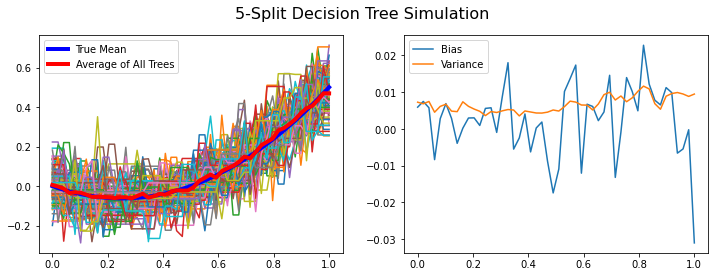

In [9]:
# tree1d(suptitle='5-Split Decision Tree Simulation', max_leaf_nodes=6)
tree1d(suptitle='5-Split Decision Tree Simulation', max_depth = 5)

# 2. {-}

## (a) {-}

In [1]:
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

X = pd.read_csv('marketing.csv')
X = pd.get_dummies(X, columns=['job', 'marital', 'education', 'default', 'housing', 'loan'])
y = np.where(X.pop('y')=='yes', 1, 0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

https://stackoverflow.com/questions/57983431/whats-the-most-space-efficient-way-to-compress-serialized-python-data

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pickle, lzma

lr = LogisticRegression(penalty='none')
rf = RandomForestClassifier(n_estimators=500, oob_score=True)
rfsmall = RandomForestClassifier(n_estimators=500, oob_score=True, min_samples_leaf=10)
rfbalance = RandomForestClassifier(n_estimators=500, oob_score=True, min_samples_leaf=10, class_weight='balanced')

for i, clf in enumerate([lr, rf, rfsmall, rfbalance]):
    fitted = clf.fit(X_train, y_train)
    with lzma.open(f'clf{i}.xz', 'wb') as f:
        f.write(pickle.dumps(fitted))

In [2]:
import lzma, pickle

with lzma.open('clf0.xz', 'rb') as f:
    lr = pickle.loads(f.read())

with lzma.open('clf1.xz', 'rb') as f:
    rf = pickle.loads(f.read())    

with lzma.open('clf2.xz', 'rb') as f:
    rfsmall = pickle.loads(f.read())    
    
with lzma.open('clf3.xz', 'rb') as f:
    rfbalance = pickle.loads(f.read())    

model = {'Logistic Regression': lr, 'RF': rf, 'RF Small': rfsmall, 'RF Balanced': rfbalance}
model

{'Logistic Regression': LogisticRegression(penalty='none'),
 'RF': RandomForestClassifier(n_estimators=500, oob_score=True),
 'RF Small': RandomForestClassifier(min_samples_leaf=10, n_estimators=500, oob_score=True),
 'RF Balanced': RandomForestClassifier(class_weight='balanced', min_samples_leaf=10,
                        n_estimators=500, oob_score=True)}

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, auc, confusion_matrix, roc_curve
from pandas import DataFrame

y_pred = np.zeros_like(y_test)
print('Base Rate: ', 1 - accuracy_score(y_test, y_pred))

res = {} 
for modelname, clf in model.items():
    y_pred = clf.predict(X_test)
    predict_proba_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 
    
    bestIdxSet = predict_proba_test.argsort()[-1000:]
    y_select = y_test[bestIdxSet]
    
    res[modelname] = {
        'Misclassification Rate': 1 - accuracy_score(y_test, y_pred), 
        'OOB Error': 1 - clf.oob_score_ if 'RF' in modelname else None, 
        'Hit Rate in Top 1000': y_select.sum()/len(y_select), 
        'AUC': auc(fpr, tpr), 
#         'Confusion Matrix': confusion_matrix(y_test, y_pred), 
    }
    
DataFrame(res)

Base Rate:  0.11528150134048254


,Logistic Regression,RF,RF Small,RF Balanced
Misclassification Rate,0.115483,0.125201,0.115885,0.229960
OOB Error,NaN,0.128652,0.117725,0.235648
Hit Rate in Top 1000,0.291000,0.432000,0.383000,0.384000
AUC,0.664587,0.681964,0.709595,0.709954


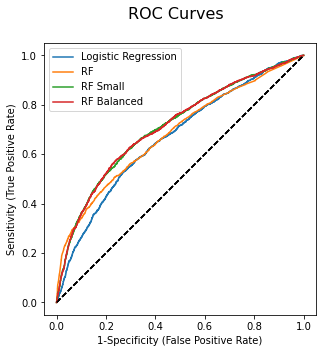

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for name, clf in model.items():
    predict_proba_test = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, predict_proba_test) 
    ax.plot(fpr, tpr, label=name)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set( aspect=1, 
            xlabel='1-Specificity (False Positive Rate)', 
            ylabel='Sensitivity (True Positive Rate)')
    
fig.suptitle('ROC Curves', fontsize=16)
plt.legend()
plt.show()

In [6]:
def report_confusion(clf, threshold):
    y_pred = clf.predict(X_test)
    predict_proba_test = clf.predict_proba(X_test)[:, 1]
    estimate = predict_proba_test > threshold

    tp = (y_test & estimate).sum()
    fp = ((1-y_test) & estimate).sum()
    fn = (y_test & (1-estimate)).sum()
    tn = ((1-y_test) & (1-estimate)).sum()

    print('Misclassification Rate: ', (fp + fn)/(tp + fp + fn + tn), '\n')
    return DataFrame([[tp, fp], [fn, tn]], columns=['True 1', 'True 0'], index=['Guess 1', 'Guess 0'])

report_confusion(rfbalance, threshold=0.5)

Misclassification Rate:  0.2299597855227882 



,True 1,True 0
Guess 1,890,2601
Guess 0,830,10599


In [7]:
report_confusion(rfsmall, threshold=0.5)

Misclassification Rate:  0.11588471849865951 



,True 1,True 0
Guess 1,11,20
Guess 0,1709,13180


In [8]:
report_confusion(rfsmall, threshold=0.15)

Misclassification Rate:  0.22861930294906166 



,True 1,True 0
Guess 1,880,2571
Guess 0,840,10629


# 3. {-}

## (a) {-}

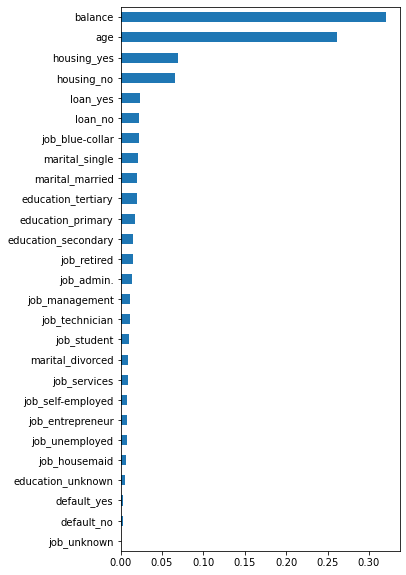

In [30]:
DataFrame({'Importance': rfbalance.feature_importances_}, index=X.columns)\
            .sort_values(by='Importance')\
            .plot(kind='barh', legend=None, figsize=(5, 10))
plt.show()

## (b) {-}

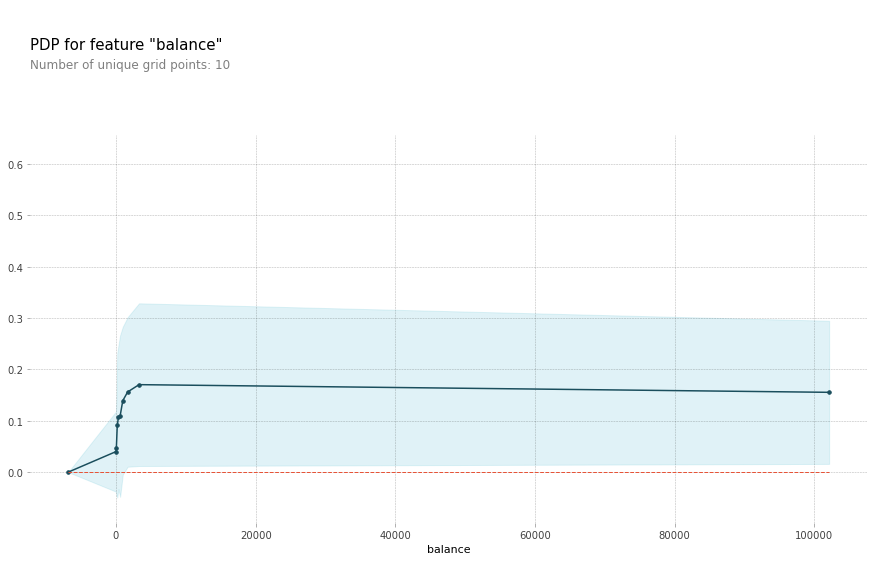

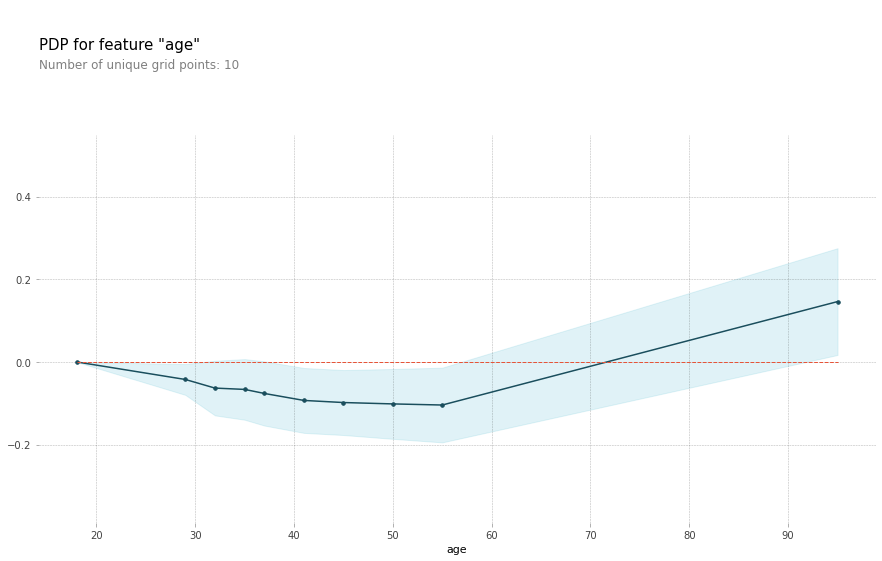

In [43]:
from pdpbox import pdp

pdp_obj = pdp.pdp_isolate(model=rfbalance, dataset=X_train, model_features=X_train.columns, feature='balance')
fig, ax = pdp.pdp_plot(pdp_obj, 'balance')

pdp_obj = pdp.pdp_isolate(model=rfbalance, dataset=X_train, model_features=X_train.columns, feature='age')
fig, ax = pdp.pdp_plot(pdp_obj, 'age')

# 4. {-}

## (a) {-}

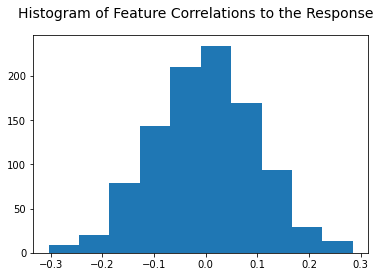

In [2]:
from scipy.stats import norm, pearsonr
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(0)

def get_data(n):
    p = 1000
    X = norm().rvs(n*p).reshape((n,p))
    y = norm().rvs(n)
    return X, y

n = 100
X, y = get_data(n)

corrs = np.apply_along_axis(lambda x: pearsonr(x, y)[0], 0, X)
plt.hist(corrs)
plt.suptitle('Histogram of Feature Correlations to the Response', fontsize=14)
plt.show()

## (b) {-}

In [3]:
columns_good = (abs(corrs) > 0.2)

X_good = X[:, columns_good]

X_good.shape

(100, 42)

## (c) {-}

The cross-validated MSE is 0.579, while the MSE on the test data is 0.417. 

In [4]:
from sklearn.linear_model import LassoCV
from sklearn.metrics import mean_squared_error

X_train = X_good[:round(n*0.8), :]
y_train = y[:round(n*0.8)]

X_test = X_good[-round(n*0.2):, :]
y_test = y[-round(n*0.2):]

model = LassoCV().fit(X_train, y_train)

model.mse_path_.mean(axis=1).min(), mean_squared_error(y_test, model.predict(X_test))

(0.5794562579855869, 0.41681392483613744)

## (d) {-}

The MSE on the new data is 1.456. 

Initially we have 1000 features, out of which we selected 42 that are the most correlated to the response. This selection makes the features artificially good. 

In 3(c) we calculated the MSE on the test data, but the test data was part of ```X_good``` and also contributes to the correlation. Thus the test data 

Imagine an extreme case where we 

The MSE we calculated in 3(c) 




Previously the 42 features are chosen 

In [5]:
X, y = get_data(n)

X_good = X[:, columns_good]

mean_squared_error(y, model.predict(X_good))

1.4559170661813172